<a href="https://colab.research.google.com/github/kavindupath/Big-Data-Analytics-Clustering/blob/main/Big_data_Analytics_Clustering_Kavindu's_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
!pip install kneed
from kneed import KneeLocator
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Load Twitter user data and create a copy of the DataFrame
file_path = '/content/sample_data/twitter_user_data.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)
df_copy = df.copy()

# Data Preprocessing

In [ ]:
# Display DataFrame information (data types, non-null counts) and summary statistics
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

,_unit_id,_trusted_judgments,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count,tweet_id
count,2.005000e+04,20050.000000,20024.000000,20050.000000,20050.000000,20050.000000,2.005000e+04,2.005000e+04
mean,8.157294e+08,3.615711,0.882756,0.993221,4382.201646,0.079401,3.892469e+04,6.590000e+17
std,6.000801e+03,12.331890,0.191403,0.047168,12518.575919,2.649751,1.168371e+05,0.000000e+00
min,8.157192e+08,3.000000,0.000000,0.627200,0.000000,0.000000,1.000000e+00,6.590000e+17
25%,8.157243e+08,3.000000,0.677800,1.000000,11.000000,0.000000,2.398000e+03,6.590000e+17
50%,8.157294e+08,3.000000,1.000000,1.000000,456.000000,0.000000,1.144150e+04,6.590000e+17
75%,8.157345e+08,3.000000,1.000000,1.000000,3315.500000,0.000000,4.002750e+04,6.590000e+17
max,8.157580e+08,274.000000,1.000000,1.000000,341621.000000,330.000000,2.680199e+06,6.590000e+17


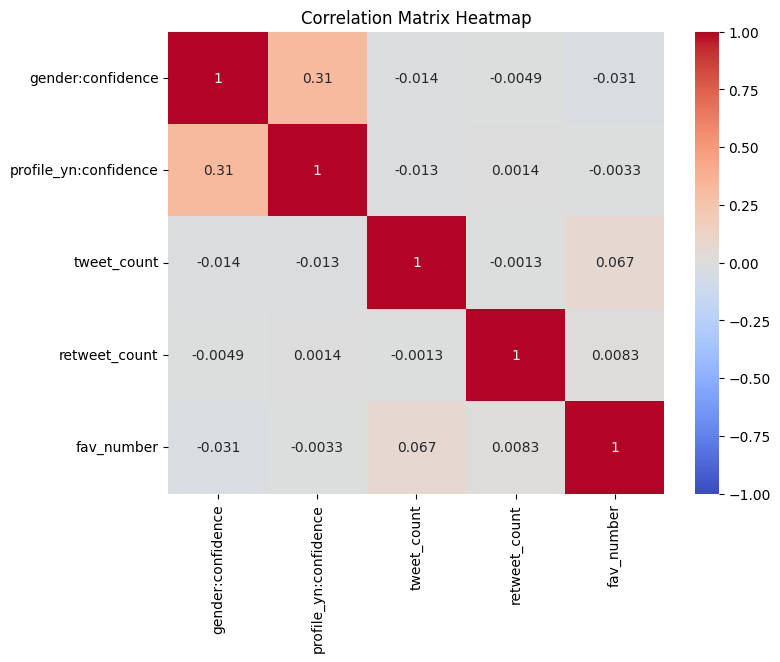

Highly correlated features:


In [ ]:
# Compute the Correlation Matrix
columns_of_interest = ['gender:confidence', 'profile_yn:confidence', 'tweet_count', 'retweet_count', 'fav_number']
correlation_matrix = df_copy[columns_of_interest].corr()

# Visualize the Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

#Find Highly Correlated Features (above 0.8 or below -0.8)
threshold = 0.8
highly_correlated = []

# Iterate through the correlation matrix to find feature pairs with high correlation
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            highly_correlated.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display the highly correlated features
print("Highly correlated features:")
for feature1, feature2, corr_value in highly_correlated:
    print(f"{feature1} and {feature2}: {corr_value:.2f}")


In [ ]:
# Drop unnecessary columns from the DataFrame to focus on relevant features for analysis
df.drop(['profile_yn','profile_yn:confidence','gender','gender:confidence','_unit_id','_last_judgment_at','created','profileimage','tweet_coord',
         '_trusted_judgments','tweet_created', 'tweet_id', 'tweet_location', 'user_timezone',
         '_golden','_unit_state', 'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'sidebar_color'
         ], axis=1, inplace=True)
df.head(5)

,description,fav_number,retweet_count,text,tweet_count
0,i sing my own rhythm.,0,0,Robbie E Responds To Critics After Win Against...,110964
1,I'm the author of novels filled with family dr...,68,0,ÛÏIt felt like they were my friends and I was...,7471
2,louis whining and squealing and all,7696,1,i absolutely adore when louis starts the songs...,5617
3,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0,Hi @JordanSpieth - Looking at the url - do you...,1693
4,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,0,Watching Neighbours on Sky+ catching up with t...,31462


In [ ]:
# Count the number of missing (NaN) values in each column of the DataFrame
df.isna().sum()

,0
description,3744
fav_number,0
retweet_count,0
text,0
tweet_count,0


In [ ]:
# Replace missing values in the 'description' and 'text' columns with empty strings
df['description'].fillna('', inplace=True)
df['text'].fillna('', inplace=True)

In [ ]:
# Clean text by removing non-alphabetic characters and converting to lowercase , and store the cleaned text in new columns

def clean(review):
    descrip = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    return review

df['descrip_Cleaned'] = pd.DataFrame(df['description'].apply(lambda x: clean(x)))
df['text_Cleaned'] = pd.DataFrame(df['text'].apply(lambda x: clean(x)))
df.head()

,description,fav_number,retweet_count,text,tweet_count,descrip_Cleaned,text_Cleaned
0,i sing my own rhythm.,0,0,Robbie E Responds To Critics After Win Against...,110964,i sing my own rhythm.,robbie e responds to critics after win against...
1,I'm the author of novels filled with family dr...,68,0,ÛÏIt felt like they were my friends and I was...,7471,i'm the author of novels filled with family dr...,ûïit felt like they were my friends and i was...
2,louis whining and squealing and all,7696,1,i absolutely adore when louis starts the songs...,5617,louis whining and squealing and all,i absolutely adore when louis starts the songs...
3,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0,Hi @JordanSpieth - Looking at the url - do you...,1693,"mobile guy. 49ers, shazam, google, kleiner pe...",hi @jordanspieth - looking at the url - do you...
4,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,0,Watching Neighbours on Sky+ catching up with t...,31462,ricky wilson the best frontman/kaiser chiefs t...,watching neighbours on sky+ catching up with t...


In [ ]:
# Remove special characters (e.g., '@', '+', '(', ')', '#') from 'descrip_Cleaned' and 'text_Cleaned' columns
# Remove URLs from both columns using regex
df['descrip_Cleaned'].replace('[@+]', "", regex=True,inplace=True)
df['descrip_Cleaned'].replace('[()]', "", regex=True,inplace=True)
df['descrip_Cleaned'].replace('[#+]', "", regex=True)

url_regex = r"(https?://)?(www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(/[a-zA-Z0-9%._-]*)*"
df['descrip_Cleaned'] = df['descrip_Cleaned'].replace(url_regex, "", regex=True)


df['text_Cleaned'].replace('[@+]', "", regex=True,inplace=True)
df['text_Cleaned'].replace('[()]', "", regex=True,inplace=True)
df['text_Cleaned'].replace('[#+]', "", regex=True)

url_regex = r"(https?://)?(www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(/[a-zA-Z0-9%._-]*)*"
df['text_Cleaned'] = df['text_Cleaned'].replace(url_regex, "", regex=True)

In [ ]:
# Tokenize and clean the 'descrip_Cleaned' column
df['descrip_Cleaned'] = [nltk.word_tokenize(tweet) for tweet in df['descrip_Cleaned']]
descrip_new = [ [word for word in tweet if word.isalpha()] for tweet in df['descrip_Cleaned']]

# Remove stopwords from 'descrip_Cleaned'
stop_words = set(stopwords.words('english'))
descrip_new_alpha = [ [word for word in tweet if word not in stop_words] for tweet in descrip_new]

# Tokenize and clean the 'text_Cleaned' column
df['text_Cleaned'] = [nltk.word_tokenize(tweet) for tweet in df['text_Cleaned']]
text_new = [ [word for word in tweet if word.isalpha()] for tweet in df['text_Cleaned']]

# Remove stopwords from 'text_Cleaned'
text_new_alpha = [ [word for word in tweet if word not in stop_words] for tweet in text_new]


In [ ]:
# Lemmatize words in the 'descrip_Cleaned' column to reduce them to their base form
description_new_lemma = []
lemma = nltk.WordNetLemmatizer()
for each_row in descrip_new_alpha:
    description_new_lemma.append([lemma.lemmatize(word) for word in each_row])
df['descrip_Cleaned'] = [" ".join(desc) for desc in description_new_lemma]

# Lemmatize words in the 'text_Cleaned' column
text_new_lemma = []
lemma2 = nltk.WordNetLemmatizer()
for each_row in text_new_alpha:
    text_new_lemma.append([lemma2.lemmatize(word) for word in each_row])
df['text_Cleaned'] = [" ".join(desc) for desc in text_new_lemma]


In [ ]:
# scaling
df['tweet_count'] = np.log1p(df['tweet_count'])
df['retweet_count'] = np.log1p(df['retweet_count'])
df['fav_number'] = np.log1p(df['fav_number'])

df.head(3)

,description,fav_number,retweet_count,text,tweet_count,descrip_Cleaned,text_Cleaned
0,i sing my own rhythm.,0.000000,0.000000,Robbie E Responds To Critics After Win Against...,11.616970,sing rhythm,robbie e responds critic win eddie edward worl...
1,I'm the author of novels filled with family dr...,4.234107,0.000000,ÛÏIt felt like they were my friends and I was...,8.918918,author novel filled family drama romance,felt like friend living story retired
2,louis whining and squealing and all,8.948586,0.693147,i absolutely adore when louis starts the songs...,8.633731,louis whining squealing,absolutely adore louis start song hit hard fee...


In [ ]:
# Extract features from 'descrip_Cleaned' using TF-IDF with a maximum of 100 features
tfidf_vectorizer = TfidfVectorizer(max_features=100)
x = tfidf_vectorizer.fit_transform(df['descrip_Cleaned']).toarray()

# Extract features from 'text_Cleaned' using TF-IDF with the same setup
tfidf_vectorizer = TfidfVectorizer(max_features=100)
y = tfidf_vectorizer.fit_transform(df['text_Cleaned']).toarray()


In [ ]:
# Drop the original 'description' and 'text' columns from the DataFrame as they are no longer needed
df.drop(['description', 'text'], axis=1, inplace=True)

# Display the first 3 rows of the updated DataFrame
df.head(3)

# Convert the TF-IDF feature arrays into DataFrames
A = pd.DataFrame(x)
B = pd.DataFrame(y)

# Concatenate the original DataFrame with the TF-IDF feature DataFrames
X = pd.concat([df, A, B], join='outer', axis=1)

# Display the shape of the final DataFrame
X.shape


(20050, 205)

In [ ]:
# Drop the 'descrip_Cleaned' and 'text_Cleaned' columns as they are no longer needed
X.drop(['descrip_Cleaned'], axis=1, inplace=True)
X.drop(['text_Cleaned'], axis=1, inplace=True)

# Display information about the updated DataFrame
X.info()

# Rename columns to ensure they have string names
X = X.rename(str, axis="columns")

# Check for any remaining missing values in the DataFrame
X.isna().sum()

# Remove rows with missing values
X.dropna(inplace=True)

# Display the first 5 rows of the cleaned DataFrame
X.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Columns: 203 entries, fav_number to 99
dtypes: float64(203)
memory usage: 31.1 MB


,fav_number,retweet_count,tweet_count,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.000000,11.616970,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,4.234107,0.000000,8.918918,0.0,0.0,0.000000,0.0,0.0,0.707435,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.948586,0.693147,8.633731,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.313206,0.000000,7.434848,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.527258,0.000000,10.356568,0.0,0.0,0.431856,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# K-Means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

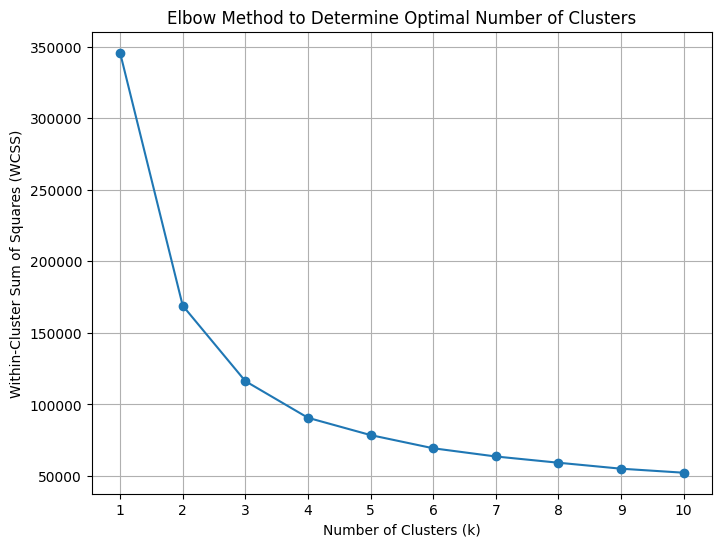

In [ ]:
# Finding the Optimal Number of Clusters using the Elbow Method

# Calculate Within-Cluster Sum of Squares (WCSS) for different numbers of clusters
wcss = []
max_clusters = 10  # Define the maximum number of clusters to test

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method Graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-')  # Plot WCSS against the number of clusters
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

In [ ]:
# Using kneed to find the optimal number of clusters
kneedle = KneeLocator(range(1, max_clusters + 1), wcss, curve='convex', direction='decreasing')

# Get the optimal number of clusters
optimal_k = kneedle.elbow
print(f'The optimal number of clusters is: {optimal_k}')

The optimal number of clusters is: 3


In [ ]:
# Initialize and fit the KMeans clustering model with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Evaluation

In [ ]:
# Evaluation
kmeans_silhouette = silhouette_score(X, kmeans_labels)
print(f'K-Means Silhouette Score: {kmeans_silhouette}')

K-Means Silhouette Score: 0.4349244754624902


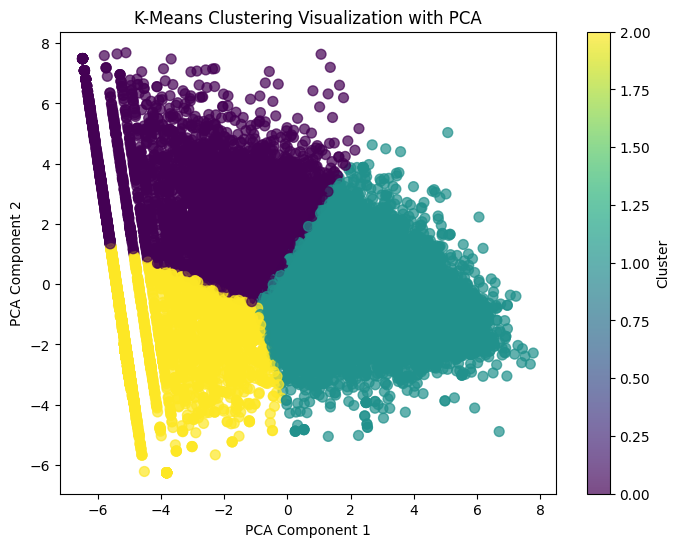

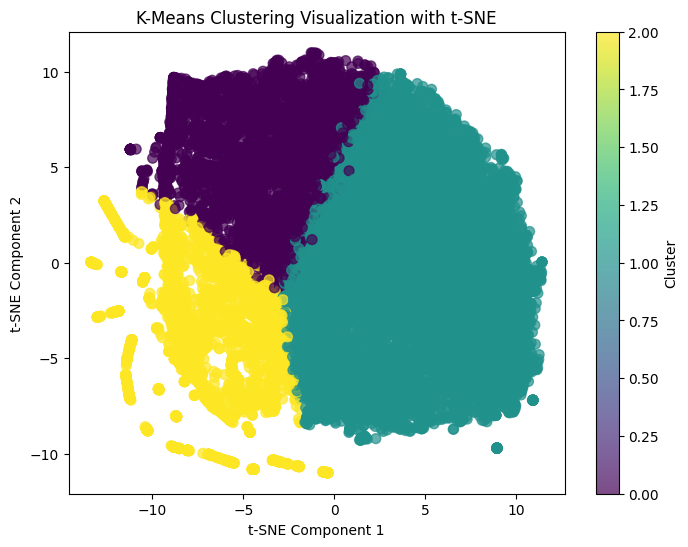

In [ ]:
#Visualizing Clusters with PCA and t-SNE

# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(X)

# t-SNE for Dimensionality Reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
reduced_features_tsne = tsne.fit_transform(X)

# Visualization using PCA
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features_pca[:, 0], reduced_features_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('K-Means Clustering Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Visualization using t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('K-Means Clustering Visualization with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
#Add cluster labels to the DataFrame
X['Cluster'] = kmeans_labels

#Summary Statistics for Each Cluster
cluster_summary = X.groupby('Cluster').describe().T
print(cluster_summary)

Cluster                     0             1            2
fav_number count  4511.000000  11031.000000  4508.000000
           mean      3.603903      7.915595     0.865100
           std       1.999627      1.489467     1.307475
           min       0.000000      4.369448     0.000000
           25%       2.197225      6.838405     0.000000
...                       ...           ...          ...
99         min       0.000000      0.000000     0.000000
           25%       0.000000      0.000000     0.000000
           50%       0.000000      0.000000     0.000000
           75%       0.000000      0.000000     0.000000
           max       1.000000      1.000000     1.000000

[1624 rows x 3 columns]


<ipython-input-87-caa24ade269a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=X["Cluster"], palette= "flare")


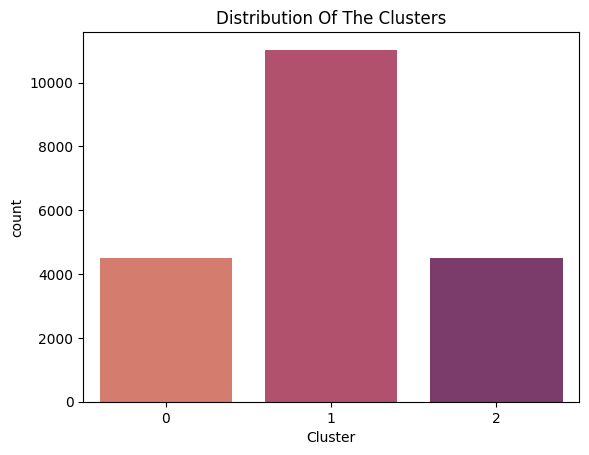

In [ ]:
#Plotting countplot of clusters
pl = sns.countplot(x=X["Cluster"], palette= "flare")
pl.set_title("Distribution Of The Clusters")
plt.show()

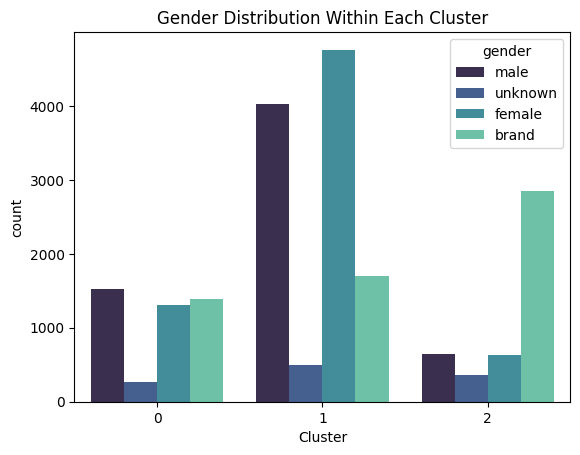

In [ ]:
# Visualize the distribution of genders within each cluster using a count plot
pl = sns.countplot(x=X["Cluster"], hue=df_copy["gender"], palette="mako")
pl.set_title("Gender Distribution Within Each Cluster")
plt.show()